# Tools (도구)

도구(Tools) 는 에이전트가 특정 행동을 수행하기 위해 호출하는 구성 요소입니다.  
이들은 모델이 명확히 정의된 입력과 출력을 통해 외부 세계와 상호작용할 수 있도록 하여 모델의 기능을 확장합니다.

도구는 호출 가능한 함수(callable function) 와 그에 대한 입력 스키마(input schema) 를 캡슐화합니다.
이러한 도구들은 호환되는 채팅 모델(chat model) 에 전달될 수 있으며, 모델은 도구를 언제, 어떤 인수(argument) 로 호출할지 스스로 결정할 수 있습니다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model

# model = init_chat_model("gpt-5-nano", model_provider="openai")
model = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

## 도구 정의 

가장 간단하게 도구를 만드는 방법은 @tool 데코레이터를 사용하는 것입니다.  

**Type hints** 는 필수입니다. 이들은 도구의 **입력 스키마(input schema)** 를 정의하기 때문입니다.  
**독스트링(docstring)** 은 모델이 도구의 목적을 이해할 수 있도록 **간결하면서도 유용한 정보**를 포함해야 합니다.

In [3]:
from langchain.tools import tool

@tool
def search_db(query: str, limit: int = 10) -> str:
    """검색어(query)에 해당하는 고객 데이터베이스 레코드를 조회합니다.

    Args:
        query: 검색할 키워드 또는 문장
        limit: 반환할 최대 결과 개수
    """
    return f"'{query}'에 대한 검색 결과 {limit}개를 찾았습니다."

search_db

StructuredTool(name='search_db', description='검색어(query)에 해당하는 고객 데이터베이스 레코드를 조회합니다.\n\nArgs:\n    query: 검색할 키워드 또는 문장\n    limit: 반환할 최대 결과 개수', args_schema=<class 'langchain_core.utils.pydantic.search_db'>, func=<function search_db at 0x0000018D7C99E200>)

### 도구 속성 사용자 정의
기본적으로 도구의 이름은 **함수 이름**에서 가져옵니다.  
더 설명적인 이름이 필요할 경우에는 이를 **재정의(override)** 할 수 있습니다.  
또한, 모델이 도구를 더 명확하게 이해하도록 하기 위해, 자동으로 생성된 도구 설명을 **재정의(override)** 할 수 있습니다.

In [4]:
@tool("web_search")  # 사용자 정의 도구 이름 설정
def search(query: str) -> str:
    """웹에서 정보를 검색합니다."""
    return f"'{query}'에 대한 검색 결과입니다."

print(search.name)  

web_search


더 명확한 모델 지침을 위해 자동 생성된 도구 설명을 재정의할 수 있습니다.

In [5]:
@tool("calculator", description="산술 계산을 수행합니다. 수학 문제를 풀 때 이 도구를 사용하세요.")
def calc(expression: str) -> str:
    """수학 표현식을 계산합니다."""
    return str(eval(expression))
calc

StructuredTool(name='calculator', description='산술 계산을 수행합니다. 수학 문제를 풀 때 이 도구를 사용하세요.', args_schema=<class 'langchain_core.utils.pydantic.calculator'>, func=<function calc at 0x0000018D7C99E520>)

### 고급 스키마 정의
Pydantic 모델이나 JSON 스키마를 사용하여 복잡한 입력을 정의합니다.

In [6]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool

# 입력 데이터 구조 정의 (Pydantic 사용)
class WeatherInput(BaseModel):
    """날씨 질의에 사용할 입력 스키마"""
    location: str = Field(description="도시 이름 또는 좌표를 입력합니다.")
    units: Literal["celsius", "fahrenheit"] = Field(
        default="celsius",
        description="온도 단위 선택 (섭씨 또는 화씨)"
    )
    include_forecast: bool = Field(
        default=False,
        description="5일치 예보 포함 여부"
    )

# 도구(tool) 정의: 날씨 정보를 조회하는 함수
@tool(args_schema=WeatherInput)
def get_weather(
    location: str,
    units: str = "celsius",
    include_forecast: bool = False
) -> str:
    """현재 날씨와 (옵션) 5일 예보 정보를 반환"""
    # 단위에 따른 임시 온도값 설정 (섭씨 22도 / 화씨 72도)
    temp = 22 if units == "celsius" else 72
    
    # 기본 날씨 문자열 구성
    result = f"{location}의 현재 기온: {temp}도 {units[0].upper()}"
    
    # 예보 포함 시, 추가 정보 출력
    if include_forecast:
        result += "\n다음 5일간 날씨: 맑음"
    
    return result

In [7]:
get_weather.invoke({"location": "Seoul"})

'Seoul의 현재 기온: 22도 C'

- LangChain 내장 도구 사용

In [8]:
from langchain_tavily import TavilySearch

# 웹 검색을 도구
tavily = TavilySearch(max_results=2)

# 도구 테스트
print(tavily.invoke("LangGraph에서 '노드(node)'란 무엇인가요?"))

{'query': "LangGraph에서 '노드(node)'란 무엇인가요?", 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.ibm.com/kr-ko/think/topics/langgraph', 'title': 'LangGraph란 무엇인가요? - IBM', 'content': '노드: LangGraph에서 노드는 AI 워크플로 안에 있는 개별 구성 요소 또는 에이전트를 나타냅니다. 노드는 특정 방식으로 상호 작용하는 "행위자"라고 볼 수 있습니다.', 'score': 0.90849644, 'raw_content': None}, {'url': 'https://blog.naver.com/pjt3591oo/223861729229?viewType=pc', 'title': 'langgraph 소개 및 기본개념 : 네이버 블로그', 'content': '· 노드(nodes): 그래프의 작업 단위\u200b 노드는 그래프에서 실제 작업을 수행하는 단위입니다. 각 노드는 특정 로직을 담당합니다. 작업은 LLM 호출, 데이터', 'score': 0.87605256, 'raw_content': None}], 'response_time': 1.02, 'request_id': '4c674d78-29d2-4d1e-b579-f68d1dbf7b85'}


In [9]:
import json

# LLM에 입력 되는 값 확인
print("**** 도구 이름 ****")
print(tavily.name)
print()
print("**** 도구 설명 ****")
print(tavily.description)
print()
print("**** 도구 인자 ****")
print(json.dumps(tavily.args_schema.model_json_schema(), indent=2))

**** 도구 이름 ****
tavily_search

**** 도구 설명 ****
A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.

**** 도구 인자 ****
{
  "description": "Input for [TavilySearch]",
  "properties": {
    "query": {
      "description": "Search query to look up",
      "title": "Query",
      "type": "string"
    },
    "include_domains": {
      "anyOf": [
        {
          "items": {
            "type": "string"
          },
          "type": "array"
        },
        {
          "type": "null"
        }
      ],
      "default": [],
      "description": "A list of domains to restrict search results to.\n\n        Use this parameter when:\n        1. The user explicitly requests inf

### Agent 에 도구 제공

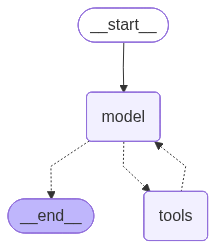

In [10]:
from langchain.agents import create_agent

# ReAct 에이전트 생성
agent = create_agent(
    model=model,  
    tools = [tavily, search_db, search]                    # 에이전트가 사용할 도구 목록
)
agent

In [13]:
result = agent.invoke(
    {"messages": [
        {'role': 'system', "content": "당신은 도움이 되는 어시스턴트입니다. 주어진 도구를 이용해 답변하세요."},
        {"role": "user", "content": "지금 서울 날씨가 어때?"}
    ]}
)

result['messages'][-1].pretty_print()

================================== Ai Message ==================================

지금 서울 날씨는 맑고 기온은 20도입니다.


In [12]:
for event in agent.stream(
    {"messages": [
        {'role': 'system', "content": "당신은 도움이 되는 어시스턴트입니다. 주어진 도구를 이용해 답변하세요."},
        {"role": "user", "content": "지금 서울 날씨가 어때?"}
    ]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

지금 서울 날씨가 어때?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (42c888f3-7a19-4927-88aa-524951f99169)
 Call ID: 42c888f3-7a19-4927-88aa-524951f99169
  Args:
    query: 지금 서울 날씨
================================= Tool Message =================================
Name: tavily_search

{"query": "지금 서울 날씨", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.accuweather.com/ko/kr/seoul/226081/current-weather/226081", "title": "서울특별시, 서울시, 대한민국 현재 날씨 - AccuWeather", "content": "서울특별시, 서울시, 대한민국 현재 날씨 | AccuWeather 서울특별시, 서울시 ========== 83°F 현재 위치 사용 서울특별시 서울시 83° 서울특별시, 서울시 날씨 오늘WinterCast지역 {stormName} 추적기시간별일별레이더MinuteCast®월대기질건강 및 활동 전 세계 ### 허리케인### 악천후 기상### 레이더 및 지도### 동영상 오늘시간별일별레이더MinuteCast®월대기질건강 및 활동 월요일, 8월 11일 현재 기상 PM 7:48 RealFeel® 88°  88° 서북서 4mi/h 8mi/h 71° F 10mi RealFeel® 81°  바람 남 4mi/h 돌풍 10mi/